### 1) Imports

In [1]:
# https://github.com/pasqal-io/Pulser/blob/develop/tutorials/applications/QAOA%20and%20QAA%20to%20solve%20a%20QUBO%20problem.ipynb

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pulser import Pulse
from pulser import Sequence
from pulser import Register

from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform

from pulser_simulation import Simulation
from pulser_simulation import SimConfig

from scipy.optimize import minimize
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

plt.style.use('dark_background')

In [3]:
tutorial_coupling_matrix = np.array(
    [
        [-10.0,      19.7365809,  19.7365809,  5.42015853, 5.42015853],
        [19.7365809, -10.0,       20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0,       0.85604541, 0.17675796],
        [5.42015853, 0.17675796,  0.85604541,  -10.0,      0.32306662],
        [5.42015853, 0.85604541,  0.17675796,  0.32306662, -10.0     ],
    ]
)

tutorial_coupling_matrix.shape, tutorial_coupling_matrix.sum(), tutorial_coupling_matrix.mean()

((5, 5), 96.75683228, 3.8702732911999997)

In [5]:
# Load Protein QUBO

QUBO_SIZE_LIMIT = 100
QUBO_SCALING_FACTOR = 1000

loaded_qubo = np.load('qubo_proteins.npy')

coupling_matrix = loaded_qubo[:QUBO_SIZE_LIMIT, 
                              :QUBO_SIZE_LIMIT] * QUBO_SCALING_FACTOR

coupling_matrix.shape, coupling_matrix.sum(), coupling_matrix.mean()

((100, 100), 56118.65, 5.611865)

In [6]:
coupling_matrix = tutorial_coupling_matrix

coupling_matrix.shape, coupling_matrix.sum(), coupling_matrix.mean()

((5, 5), 96.75683228, 3.8702732911999997)

In [5]:
# TODO: Classical energies for 8 atoms

Limitations:

1) Qubit count is limited to 100 on Simulator
2) Atomic coordinates are limited to sector of 50 mkm radius
3) Minimum distances between atoms are 4 mkm
4) Classical simulation time is about 60 seconds for 14 qubits 
5) Embedding time

6) SimOptions do not affect shots count

### 3) Embedding to Atomic Register

In [7]:
def qubo_to_atomic_loss(coordinate_vector, coupling_matrix, shape):  
    
    coordinates = np.reshape(coordinate_vector, shape)
    
    pairwise_distances = pdist(coordinates)
    
    global atom_distances 
    atom_distances = pairwise_distances
    
    interaction_matrix = squareform(Chadoq2.interaction_coeff /  pairwise_distances ** 6)
    
    root_mean_square_error = np.linalg.norm(interaction_matrix - coupling_matrix)
    
    return root_mean_square_error

In [8]:
COORDINATES_SCALE = 1
COORDINATES_SHIFT = 0

np.random.seed(20)


coupling_matrix_size = len(coupling_matrix)

coordinates_shape = (coupling_matrix_size, 2)

initial_coordinates = np.random.random(coordinates_shape)

initial_coordinate_vector = initial_coordinates.flatten()

coordinate_vector = initial_coordinate_vector

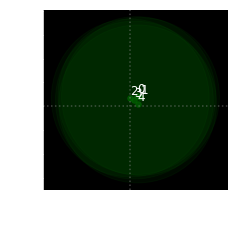

In [9]:
# Initial Coordinates

qubits_dict = dict(enumerate(initial_coordinates * COORDINATES_SCALE))

atomic_register = Register(qubits_dict)

atomic_register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1),
    draw_graph=False,
    draw_half_radius=True,
)

In [10]:
# Run Optimization Iteration

ITERATIONS_COUNT = 10000
COORDINATES_TOLERANCE = 1e-6

optimal_coordinates_result = minimize(
    fun=qubo_to_atomic_loss,
    x0=coordinate_vector,
    args=(coupling_matrix, coordinates_shape),
    method="Nelder-Mead",
    tol=COORDINATES_TOLERANCE,
    options={"maxiter": ITERATIONS_COUNT, "maxfev": None},
)

coordinate_vector = optimal_coordinates_result.x

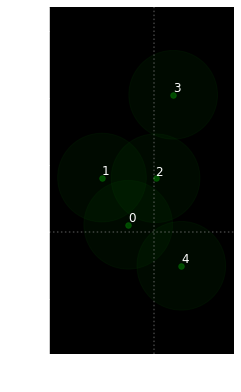

In [11]:
# Optimal Coordinates

optimal_coordinates = np.reshape(coordinate_vector, coordinates_shape)

optimal_coordinates = optimal_coordinates * COORDINATES_SCALE - COORDINATES_SHIFT


qubits_dict = dict(enumerate(optimal_coordinates))

atomic_register = Register(qubits_dict)

atomic_register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1),
    draw_graph=False,
    draw_half_radius=True,
)

In [12]:
MAX_RADIAL_DISTANCE = 50

too_far = np.linalg.norm(optimal_coordinates, axis=1) > MAX_RADIAL_DISTANCE

too_far_indices = np.argwhere(too_far).squeeze()

too_far_percent = too_far.sum() / len(too_far)

too_far_percent

0.0

In [13]:
selected_qubits_dict = {qubit: coordinates for qubit, coordinates in qubits_dict.items()
                        if qubit not in too_far_indices}

len(selected_qubits_dict)

5

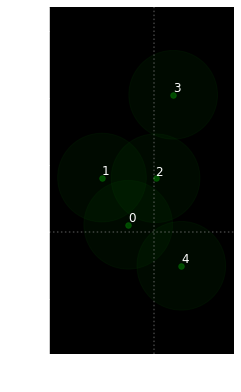

In [14]:
atomic_register = Register(selected_qubits_dict)

atomic_register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1),
    draw_graph=False,
    draw_half_radius=True,
)

$$ H= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2} \sigma_i^z+\sum_{j} ... $$

### 4) Quantum Adiabatic Algorithm (QAA)

In [15]:
# Omega Maximum

OMEGA_MAX_LIMIT = 15

positive_coupling_coefficients = coupling_matrix[coupling_matrix > 0].flatten()

omega_maximum = np.median(positive_coupling_coefficients)

omega_maximum = min(OMEGA_MAX_LIMIT, omega_maximum)

omega_maximum

3.13810197

In [16]:
DELTA_0 = -5
DELTA_F = -DELTA_0

TIME_NANOSECONDS = 4000

In [17]:
# Modulating Waveforms

amplitude_modulating_waveform = InterpolatedWaveform(TIME_NANOSECONDS, [1e-9, omega_maximum, 1e-9])

frequency_modulating_waveform = InterpolatedWaveform(TIME_NANOSECONDS, [DELTA_0, 0, DELTA_F])

In [18]:
# Pulse

adiabatic_pulse = Pulse(
    amplitude=amplitude_modulating_waveform,
    detuning=frequency_modulating_waveform,
    phase=0,
)

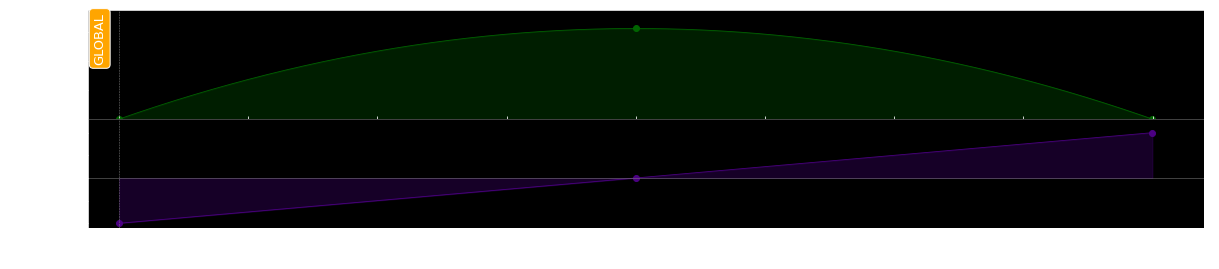

In [19]:
sequence = Sequence(atomic_register, Chadoq2)
sequence.declare_channel("ising", "rydberg_global")
sequence.add(adiabatic_pulse, "ising")
sequence.draw()

In [20]:
RUNS_COUNT = 10
SAMPLES_PER_RUN = 10000

configuration = SimConfig(runs=RUNS_COUNT, samples_per_run=SAMPLES_PER_RUN)

simulation = Simulation(sequence=sequence, config=configuration)

simulation.reset_config()

simulation.set_config(configuration)

results = simulation.run(progress_bar=True)

final_statevector = results.get_final_state()

counts = results.sample_final_state()

counts

10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.06s. Est. time left: 00:00:00:00
30.0%. Run time:   0.11s. Est. time left: 00:00:00:00
40.0%. Run time:   0.13s. Est. time left: 00:00:00:00
50.0%. Run time:   0.17s. Est. time left: 00:00:00:00
60.0%. Run time:   0.20s. Est. time left: 00:00:00:00
70.0%. Run time:   0.22s. Est. time left: 00:00:00:00
80.0%. Run time:   0.25s. Est. time left: 00:00:00:00
90.0%. Run time:   0.33s. Est. time left: 00:00:00:00
Total run time:   0.36s


Counter({'00010': 2,
         '00011': 28,
         '00101': 1,
         '00111': 217,
         '01000': 1,
         '01001': 4,
         '01010': 1,
         '01011': 717,
         '10010': 14,
         '10011': 15})

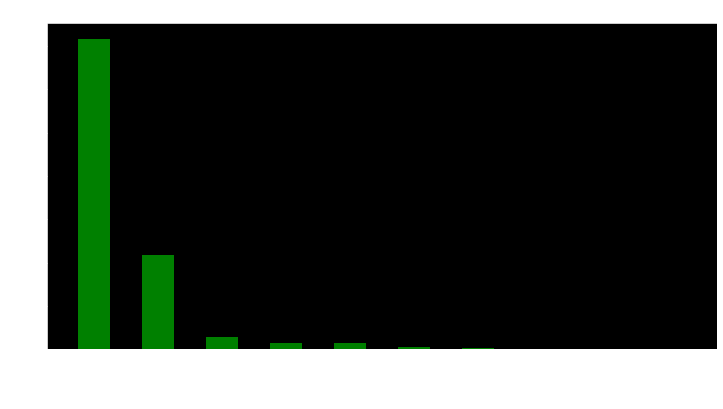

In [23]:
# Plot Histogram

descending_counts = dict(sorted(counts.items(), key=lambda item: -item[1]))   

plt.figure(figsize=(12, 6))
    
plt.bar(descending_counts.keys(), 
        descending_counts.values(), width=0.5, color="g")    

plt.xticks(rotation="vertical")

plt.title("Simulated state counts")
plt.xlabel("State")
plt.ylabel("Count")
plt.show()

### 2) Classical Search

In [26]:
selected_qubits = list(selected_qubits_dict.keys())

selected_qubits_count = len(selected_qubits)

selected_qubits

[0, 1, 2, 3, 4]

In [27]:
selected_coupling_matrix = coupling_matrix[selected_qubits][:, selected_qubits]

selected_coupling_matrix.shape

(5, 5)

In [28]:
selected_state_strings = np.array(list(counts.keys()))

selected_bit_strings = np.frombuffer(selected_state_strings,'<U1')

selected_bits = selected_bit_strings.astype('uint8')

selected_state_bits = selected_bits.reshape(-1, selected_qubits_count)

selected_state_bits

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 1, 1]], dtype=uint8)

In [29]:
state_indices = np.arange(2 ** selected_qubits_count)

binarize = np.vectorize(np.binary_repr)

state_strings = binarize(state_indices, selected_qubits_count)

state_indices_vector = state_indices.reshape(-1, 1).astype(np.uint8)

state_little_bits = np.unpackbits(state_indices_vector, 
                                  count=selected_qubits_count, 
                                  bitorder='little',
                                  axis=1)

all_state_bits = np.flip(state_little_bits, axis=1)

all_state_bits

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 1],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 1, 1],
       [1, 0, 1, 0, 0],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 1],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 1],
       [1, 1, 0, 1, 0],
       [1, 1, 0, 1, 1],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1]], dtype=uint8)

In [30]:
costs = np.diag(selected_state_bits @ selected_coupling_matrix @ selected_state_bits.T)

costs.shape

(10,)

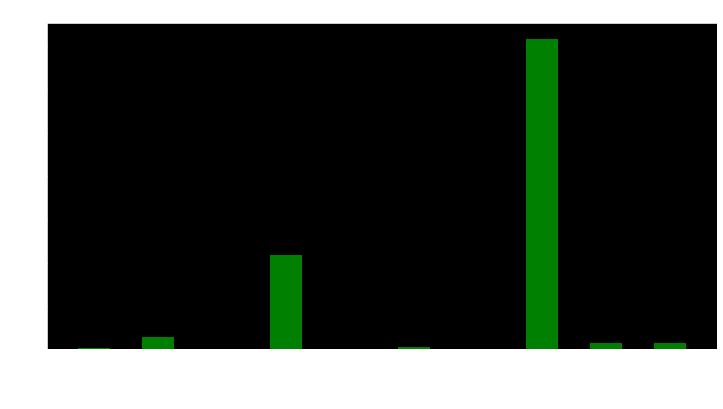

In [32]:
state_costs = dict(zip(counts, costs))


plt.figure(figsize=(12, 6))
    
plt.bar(counts.keys(), 
        counts.values(), width=0.5, color="g")    

plt.xticks(rotation="vertical")

plt.title("Simulated state counts")
plt.xlabel("State")
plt.ylabel("Count")
plt.show()

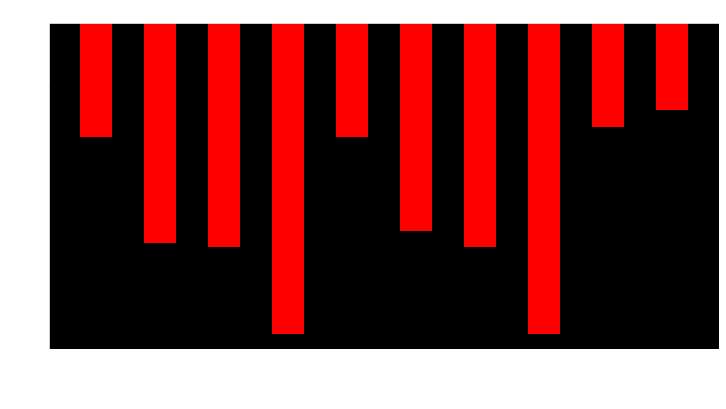

In [34]:
plt.figure(figsize=(12, 6))

plt.bar(state_costs.keys(), 
        state_costs.values(), width=0.5, color="r")   

plt.xticks(rotation="vertical")

plt.title("Simulated state counts")
plt.xlabel("State")
plt.ylabel("Count")
plt.show()

### 5) Time Evolution

In [81]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [101]:
masked_coupling_matrix = coupling_matrix[~too_far][:, ~too_far]

masked_coupling_matrix.shape

(7, 7)

In [107]:
costs = []

durations = 1000 * np.linspace(1, 100, 10)

for duration in durations:
    
    print("duration:", duration)
    
    seq = Sequence(atomic_register, Chadoq2)
    
    seq.declare_channel("ising", "rydberg_global")
    
    amplitude_modulating_waveform = InterpolatedWaveform(duration, [1e-9, omega_maximum, 1e-9])
    frequency_modulating_waveform = InterpolatedWaveform(duration, [DELTA_0, 0, DELTA_F])
        
    adiabatic_pulse = Pulse(
        amplitude=amplitude_modulating_waveform,
        detuning=frequency_modulating_waveform,
        phase=0,
    )
    
    seq.add(adiabatic_pulse, "ising")
    
    simul = Simulation(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()    
    
    costs.append(get_cost(count_dict, masked_coupling_matrix) / 3)

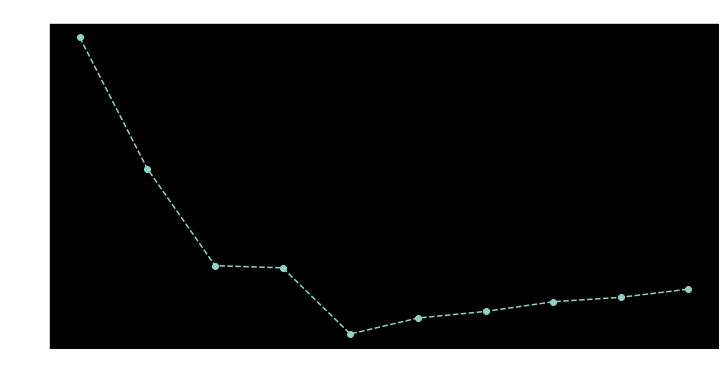

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(durations, np.array(costs), "--o")

plt.title("Pasqal Pulser - Sampled QUBO Energies")
plt.xlabel("Time evolution duration (µs)")
plt.ylabel("Energy")
plt.show()

### 6) QAOA

In [14]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(atomic_register, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

In [15]:
def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = Simulation(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

In [16]:
np.random.seed(123)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

In [17]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])

In [18]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # MIS indexes
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

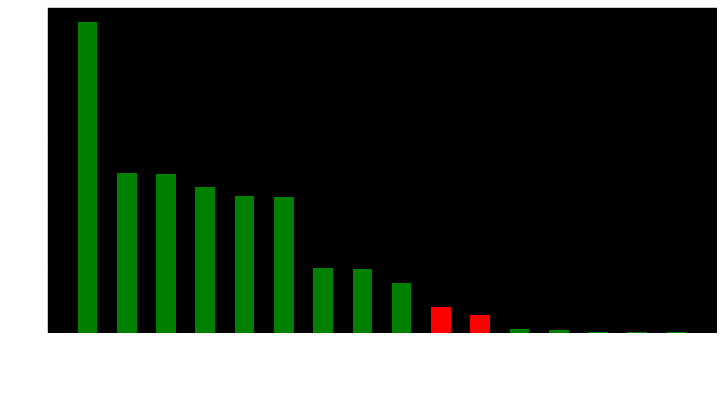

In [19]:
plot_distribution(example_dict)

#### Optimization

In [20]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

#### QAOA

In [21]:
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

In [22]:
scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
    
        res = minimize(
            func,
            args=coupling_matrix,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    
    except Exception as e:
        pass

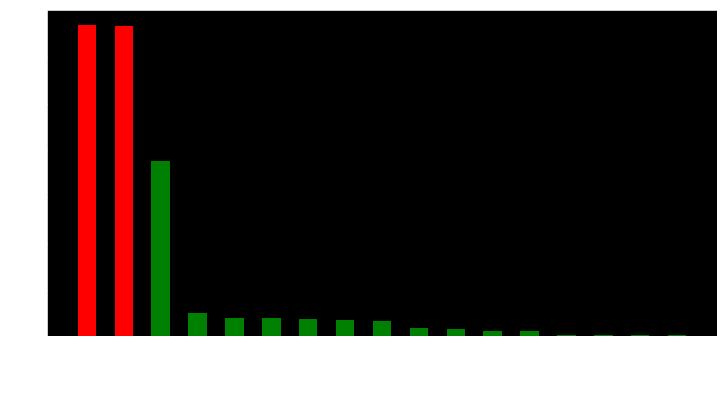

In [23]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)